In [5]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import scipy.ndimage as ndimage
from wrf import(getvar,interplevel, to_np, latlon_coords, interpline, get_cartopy, cartopy_xlim, cartopy_ylim,ALL_TIMES, vertcross, smooth2d, CoordPair, GeoBounds)
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc
from metpy.units import units
import pandas as pd
import pytz
import glob
import datetime as dt
import matplotlib.dates as mdates
############################################
#mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
############################################
import wrf

In [13]:
def grid_xy(lat, lon, mlat,mlon):# The Lat/lon of paradise
    wp_lat = lat
    wp_lon = lon
    #Subtracting the station lat/lon from all the lat/lon points, them from there finding the minimum difference which gives the closest grid box index
    abslat = np.abs(mlat-wp_lat)
    abslon= np.abs(mlon-wp_lon)
    c = np.maximum(abslon,abslat)
    xx, yy = np.where(c == np.min(c))
    return(xx[0],yy[0]) 

In [107]:
#Data Frame Headers
#Plotting Options
style = 'vector'
increment = 0
ymax = 1500
names = ('height','wdir','wspd')

#Prepping Files For Import
path =r'/export/home/mbrewer/Documents/campfire/stares/20181109' # use your path
allFiles = glob.glob(path + "/Processed*.hpl")
print ('you have %s wind profiles to plot' %(len(allFiles)))


for k,i in enumerate(allFiles,0): #pull time from import dictionaries and append to list
    df = pd.read_csv(i, skiprows = 1, sep = '\s+', names = names)
    
    time = str(i[-19:-4])
    height = np.array(df.height).reshape(300)
    wdir = np.array(df.wdir).reshape(300)
    wspd = np.array(df.wspd).reshape(300)
    
    indx_top = np.abs(height-ymax).argmin()
    plt_range = slice(6,indx_top,1)
    DT = []
    for i in range(300):
        DT.append(time)
    
    u,v = mpcalc.wind_components(wspd * units('m/s'), wdir * units.deg)
    u = np.array(u)
    v= np.array(v)
    
    if k ==0:
        main_frame = pd.DataFrame()
        main_frame['time'] = DT[plt_range]
        main_frame.index = pd.to_datetime(main_frame.time, format = '%Y%m%d_%H%M%S')
        main_frame.index = main_frame.index.tz_localize('UTC').tz_convert('US/Pacific')
        main_frame['u'] = u[plt_range]
        main_frame['v'] = v[plt_range]
        main_frame['hgt'] = height[plt_range]
    else:
        _DF = pd.DataFrame()
        _DF['time'] = DT[plt_range]
        _DF.index = pd.to_datetime(_DF.time, format = '%Y%m%d_%H%M%S')
        _DF.index = _DF.index.tz_localize('UTC').tz_convert('US/Pacific')
        _DF['u'] = u[plt_range]
        _DF['v'] = v[plt_range]
        _DF['hgt'] = height[plt_range]
        main_frame = main_frame.append(_DF)

you have 26 wind profiles to plot


In [14]:
ds = Dataset('wrfout_d03_2018-11-09_03:00:00')
time = getvar(ds, "times",timeidx=ALL_TIMES)
z = getvar(ds, 'z',timeidx=ALL_TIMES)
ua = getvar(ds, 'ua', units ='ms-1',timeidx=ALL_TIMES)
va = getvar(ds, 'va', units ='ms-1',timeidx=ALL_TIMES)
wspd, wdir = getvar(ds, 'uvmet_wspd_wdir', units = 'ms-1', timeidx = ALL_TIMES)
lats, lons = latlon_coords(z)
u_10, v_10 =getvar(ds, 'uvmet10', timeidx = ALL_TIMES)
truck_lon = -121.57423166666667
truck_lat = 39.69727166666667
x, y = grid_xy(truck_lat, truck_lon, lats, lons)

In [11]:
X, Y = wrf.ll_to_xy(ds, truck_lat, truck_lon)

(0, 1000)

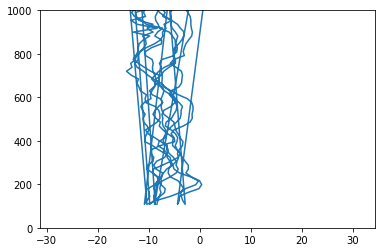

In [138]:
_df = main_frame.loc[main_frame.index >= pd.Timestamp('2018-11-08 19:00').tz_localize('US/Pacific')] #and 
df = _df.loc[_df.index <= pd.Timestamp('2018-11-08 20:00').tz_localize('US/Pacific')]
plt.plot(df.u, df.hgt)
plt.ylim(0,1000)

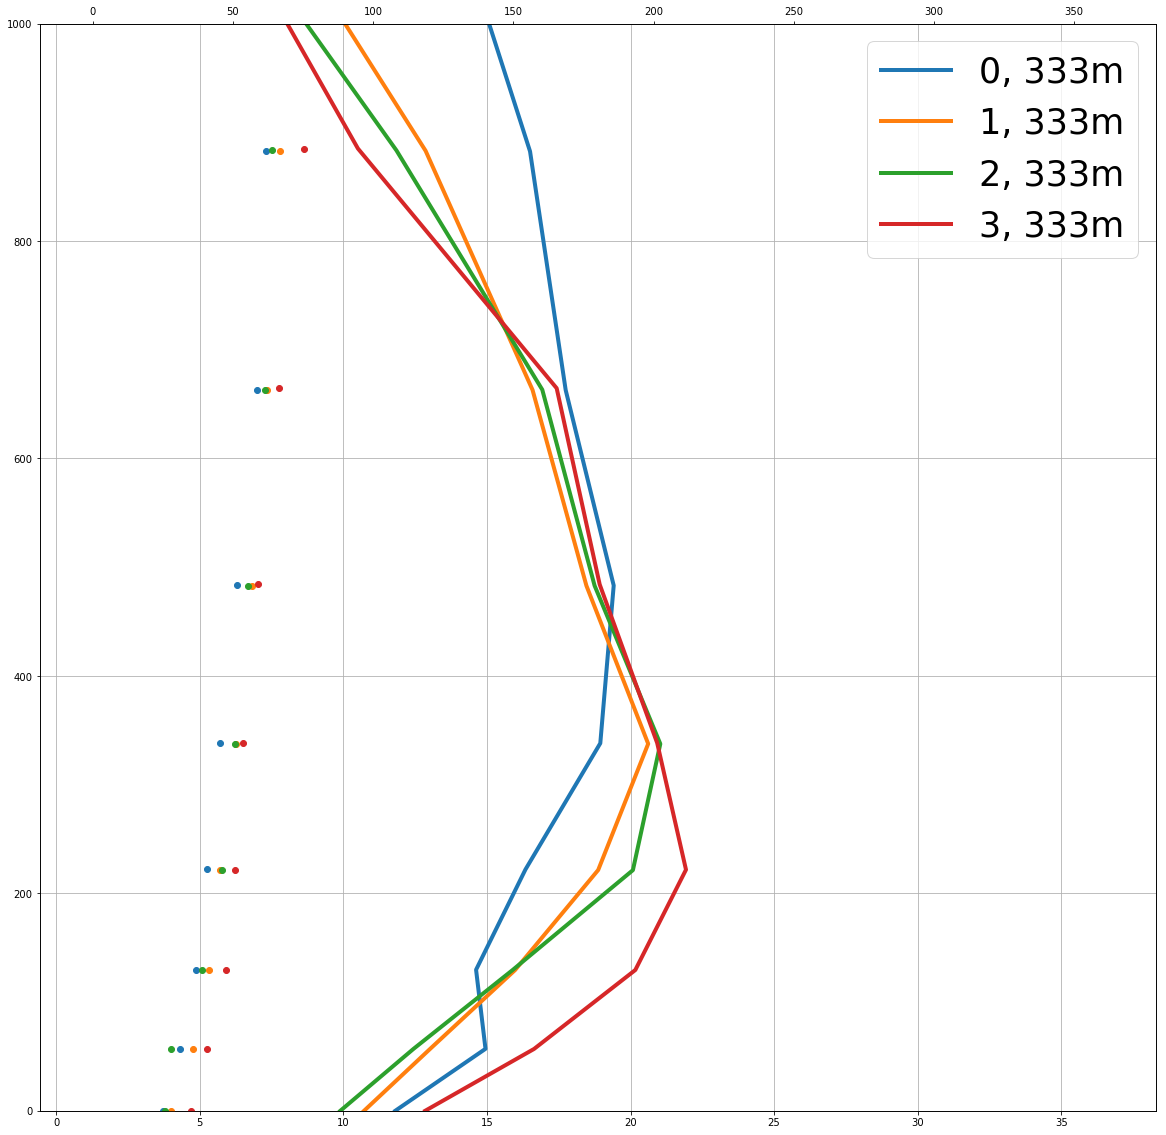

In [40]:
w = wspd[:,:,x,y]
wd = wdir[:,:,x,y]
zz = z[:,:,x,y].squeeze()
u_10, v_10 =getvar(ds, 'uvmet10', timeidx = ALL_TIMES)

fig, ax = plt.subplots(figsize = (20,20),)
ax.plot(w[0], zz[0]-zz[0,0], linewidth = 4, label = '0, 333m')
ax.plot(w[1], zz[1]-zz[1,0], linewidth = 4, label = '1, 333m')
ax.plot(w[2], zz[2]-zz[2,0], linewidth = 4, label = '2, 333m')
ax.plot(w[3], zz[3]-zz[3,0], linewidth = 4, label = '3, 333m')
ax.legend(fontsize = 35)
ax.grid()
ax.set_ylim(0,1000)

ax2 = ax.twiny()
ax2.scatter(wd[0], zz[0]-zz[0,0])
ax2.scatter(wd[1], zz[1]-zz[1,0])
ax2.scatter(wd[2], zz[2]-zz[2,0])
ax2.scatter(wd[3], zz[3]-zz[3,0])


In [ ]:
Y